# Classification models 
CDS Class, prepared by Prof. Dorien Herremans, Cheuk Kin Wai, and Yin-Jyun Luo. 


---






Let's start by loading the necessary libraries for this class. The main libraries used are numpy and pandas for data handling and [scikit learn (sklearn)](https://scikit-learn.org/stable/) for classification models. 


In [1]:
import  matplotlib.pyplot  as  plt  #  plotting  library 
import numpy as np # library for numerical calculations 
import pandas as pd # library for reading csv files

## Walkthrough example of different classification methods

To become familiar with the classification models, please follow the instructions below. 

### Problem description and preparing dataset

Let's start doing some classification on the Heart Disease dataset from Kaggle at https://www.kaggle.com/ronitf/heart-disease-uci. The dataset has 303 patients and 13 features for each patient. 

You can find the dataset at the link above, or directly load it like shown below: 


In [2]:
!wget  -P  /  -c  'https://dorienherremans.com/drop/CDS/classification/heart.csv'

data  =  pd.read_csv('heart.csv')  #  loading  dataset

data.head() #check if it's loaded correctly


--2019-10-17 18:08:12--  https://dorienherremans.com/drop/CDS/classification/heart.csv
Resolving dorienherremans.com (dorienherremans.com)... 96.127.180.74
Connecting to dorienherremans.com (dorienherremans.com)|96.127.180.74|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11328 (11K) [text/csv]
Saving to: ‘heart.csv’

eart.csv            100%[===================>]  11.06K  --.-KB/s    in 0s      

2019-10-17 18:08:13 (39.6 MB/s) - ‘heart.csv’ saved [11328/11328]



,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


Let's make the data nicer. Since the column headers are a bit heard to read, we can override them to provide more easy to understand labels:

In [3]:
# Give a better name to each column
data.columns = ['age', 'sex', 'chest_pain_type', 'resting_blood_pressure', 'cholesterol', 'fasting_blood_sugar', 'rest_ecg', 'max_heart_rate_achieved',
       'exercise_induced_angina', 'st_depression', 'st_slope', 'num_major_vessels', 'thalassemia', 'target']

Let's check how balanced our dataset is. 

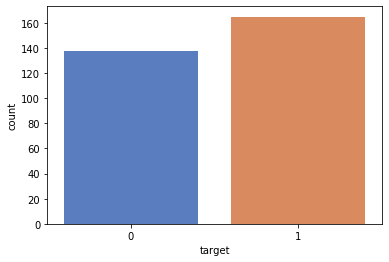

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
#breakdown by class
sns.countplot(x="target",  data=data,  palette="muted");

It's almost balanced, but not entirely, so during evaluation, let's make sure to check F1 values and AUC instead of just accuracy. 

We also need to make sure that the system recognises our data as being categorical appropriately. 

In [6]:
data.dtypes

age                          int64
sex                          int64
chest_pain_type              int64
resting_blood_pressure       int64
cholesterol                  int64
fasting_blood_sugar          int64
rest_ecg                     int64
max_heart_rate_achieved      int64
exercise_induced_angina      int64
st_depression              float64
st_slope                     int64
num_major_vessels            int64
thalassemia                  int64
target                       int64
dtype: object

This looks good. Everything is an integer, except for the continuous variables. In the case where categories are stored as strings, you need to correct this with: 

data['Class'] = pd.Categorical(data['Class'])

data['Class'] = data['Class'].cat.codes

In our case all is well. 

Looking at the header, the prediction task is now clear: we need to predict if target = 1, meaning heart disease is present. 

To properly evaluate models, we **create a test and training set** with 30% split using train_test_split. 

In [8]:
from sklearn.model_selection import train_test_split
# data = pd.get_dummies(data, drop_first=True)
# We  split the data up into a test set and a training set, 30 - 70        # train_test_split
# First argument: x data is all data without class column     # Second argument:	this is the class label column
# Random state = 0: ensures the train and test splitting is deterministic. #Otherwise every student would get a different train test split.
X_train,  X_test,  y_train,  y_test  =  train_test_split(data.drop('target',1), data['target'], test_size=0.3, random_state=0)


Most classifiers will work best if the data is normalized. We can easily do this by using the MinMaxScaler fuction. 


In [22]:
from sklearn.preprocessing import MinMaxScaler

# define a new scaler:
x_scaler = MinMaxScaler()

# fit the normalization on the training set:
x_scaler.fit(X_train)


X_train_norm = x_scaler.transform(X_train) 
# then create new and normalized training/test sets: X_train_norm = x_scaler.transform(X_train) X_test_norm = x_scaler.transform(X_test)
X_test_norm = x_scaler.transform(X_test)

### Model 1: Decision Trees

Let's import the sklearn library for CART decision trees, and define a variable 'model' to hold our CART tree model. We can specify some pruning/early stopping parameters so that the size of the tree can be adjusted. 

In [11]:
from sklearn import tree

model  =  tree.DecisionTreeClassifier(max_depth=3,  min_samples_leaf=1) # Using default parameters

Let's train the model by passing it our training data X_train and labels y_train. Note that decision trees don't need normalized data, in this case it may be easier to understand with the original data (so we are using X_train, not X_train_norm as we do in the other models): 

In [12]:
model.fit(X_train, y_train) 

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

Notice how the options above let you tweek the classifier (e.g. criterion Gini coefficient). This model trained really fast! But how good is it?

I've emphasized the importance of evaluating models using multiple metrics in class. Let's **define a function called
evaluate_on_training_set, which will print out all of out metrics**. This will save us some time throughout the lab. 

In [17]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score

def evaluate_on_training_set(y_test, y_pred):
    # Calculate AUC
    print("AUC  is:  ",  roc_auc_score(y_test,  y_pred))


    # print out recall and precision
    print(classification_report(y_test, y_pred))

    # print out confusion matrix
    print("Confusion Matrix: \n", confusion_matrix(y_test, y_pred))

    # # calculate points for ROC curve
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)

    # Plot ROC curve
    plt.plot(fpr,  tpr,  label='ROC  curve  (area  =%0.3f)'%roc_auc_score(y_test,  y_pred)) 
    plt.plot([0,  1],  [0,  1],  'k--')	#  random  predictions  curve
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False  Positive  Rate  or  (1  -  Specifity)') 
    plt.ylabel('True  Positive  Rate  or  (Sensitivity)') 
    plt.title('Receiver  Operating  Characteristic')


Using this new function we can now make predictions for our newly trained model 'model' and get the evaluation metrics: 


AUC  is:   0.8104448742746615
              precision    recall  f1-score   support

           0       0.86      0.73      0.79        44
           1       0.78      0.89      0.83        47

    accuracy                           0.81        91
   macro avg       0.82      0.81      0.81        91
weighted avg       0.82      0.81      0.81        91

Confusion Matrix: 
 [[32 12]
 [ 5 42]]


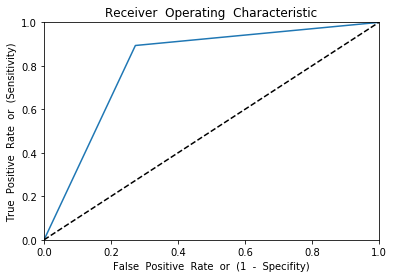

In [18]:
y_pred  =  model.predict(X_test)  #  Predicting  labels  for  our  test  set  using  model
evaluate_on_training_set(y_test,  y_pred)  #evaluate  our  model  using  new function

Finally, what does the actual tree look like? You can experiment yourself how the tree (and the accuracy) changes when we set different pruning parameters. 

[Text(390.6, 570.7800000000001, 'X[2] <= 0.5\ngini = 0.494\nsamples = 212\nvalue = [94, 118]'),
 Text(195.3, 407.70000000000005, 'X[11] <= 0.5\ngini = 0.415\nsamples = 102\nvalue = [72, 30]'),
 Text(97.65, 244.62, 'X[12] <= 2.5\ngini = 0.492\nsamples = 48\nvalue = [21, 27]'),
 Text(48.825, 81.53999999999996, 'gini = 0.328\nsamples = 29\nvalue = [6, 23]'),
 Text(146.47500000000002, 81.53999999999996, 'gini = 0.332\nsamples = 19\nvalue = [15, 4]'),
 Text(292.95000000000005, 244.62, 'X[0] <= 63.5\ngini = 0.105\nsamples = 54\nvalue = [51, 3]'),
 Text(244.125, 81.53999999999996, 'gini = 0.0\nsamples = 43\nvalue = [43, 0]'),
 Text(341.77500000000003, 81.53999999999996, 'gini = 0.397\nsamples = 11\nvalue = [8, 3]'),
 Text(585.9000000000001, 407.70000000000005, 'X[9] <= 1.95\ngini = 0.32\nsamples = 110\nvalue = [22, 88]'),
 Text(488.25, 244.62, 'X[7] <= 152.5\ngini = 0.255\nsamples = 100\nvalue = [15, 85]'),
 Text(439.425, 81.53999999999996, 'gini = 0.438\nsamples = 34\nvalue = [11, 23]'),
 Te

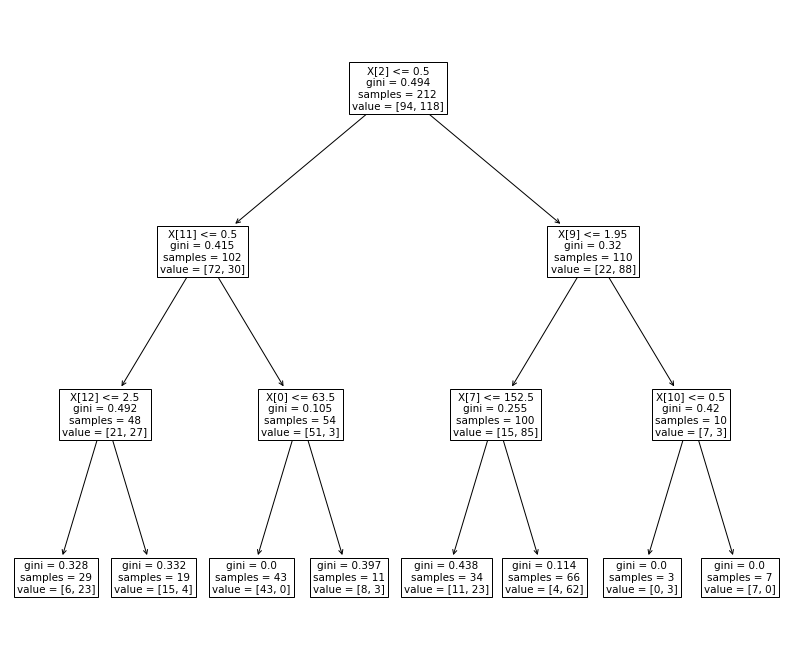

In [19]:
plt.figure(figsize=(14,12))
tree.plot_tree(model)

### Model 2: K Nearest Neighbor Classifier

Let's explore the kNN algorithm. As you've seen in class. It's a very simple algorithm, however, it needs a lot of time to compute all distances. 

Similar to before, we first load the library and define the model with parameters (here only the parameter k is needed). 

In [28]:
from sklearn.neighbors import KNeighborsClassifier

model = KNeighborsClassifier(n_neighbors=5) # Define the model with parameters


We can then proceed to train the model using the fit command and evaluate it using the function we defined before: 

AUC  is:   0.8225338491295938
              precision    recall  f1-score   support

           0       0.85      0.77      0.81        44
           1       0.80      0.87      0.84        47

    accuracy                           0.82        91
   macro avg       0.83      0.82      0.82        91
weighted avg       0.83      0.82      0.82        91

Confusion Matrix: 
 [[34 10]
 [ 6 41]]


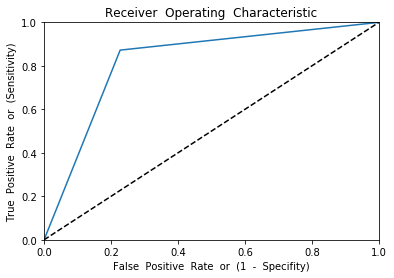

In [29]:
model.fit(X_train_norm, y_train) # Training the model

# Evaluate the model:
y_pred  =  model.predict(X_test_norm)  #  Predicting  labels  for  our  test  set  using trained
evaluate_on_training_set(y_test,  y_pred)  #evaluate  our  model  using  newly  defined  funct


It's extremely important to set a good value for k, so you will need to test this. E.g. try running the above code with k = 5. See any change? Your F1 scores should go up! 

### Model 3: Logistic Regression

Let's move on to a very powerful, yet fast model: Logistic Regression. Again, we start by loading the library and defining the model together with its parameters. 

In this case, multi_class auto will detect the number of classes automatically, C is our regularisation parameter, and solver is the optimization algorithm used to fit the model: 
* For small datasets, ‘liblinear’ is a good choice, whereas ‘sag’ and ‘saga’ are faster for large ones.
* For multiclass problems, only ‘newton-cg’, ‘sag’, ‘saga’ and ‘lbfgs’ handle multinomial loss; ‘liblinear’ is limited to one-versus-rest schemes.
* ‘newton-cg’, ‘lbfgs’, ‘sag’ and ‘saga’ handle L2 or no penalty
* ‘liblinear’ and ‘saga’ also handle L1 penalty
* ‘saga’ also supports ‘elasticnet’ penalty
* ‘liblinear’ does not handle no penalty

In [30]:
from sklearn.linear_model import LogisticRegression
model  =  LogisticRegression(C=1.0,  multi_class='auto',  solver='lbfgs')

We can the train and evaluate the model like usual: 

AUC  is:   0.7884429400386848
              precision    recall  f1-score   support

           0       0.84      0.70      0.77        44
           1       0.76      0.87      0.81        47

    accuracy                           0.79        91
   macro avg       0.80      0.79      0.79        91
weighted avg       0.80      0.79      0.79        91

Confusion Matrix: 
 [[31 13]
 [ 6 41]]


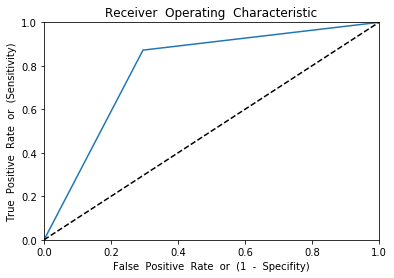

In [31]:
model.fit(X_train_norm, y_train) # Training the model

y_pred  =  model.predict(X_test_norm)  #  Predicting  labels  for  our  test  set  using trained
evaluate_on_training_set(y_test,  y_pred)  #evaluate  our  model  using  newly  defined  funct




This is a fast model again, with rather good output. 

### Model 4: Gaussian Naive Bayes

Let's create a Naive Bayes model. There are a [number of variants on this model to choose](https://scikit-learn.org/stable/modules/naive_bayes.html) from in Scikit learn, let's pick the Gaussian variant. Same thing as always, we load the library and define the model: 

In [32]:
from sklearn.naive_bayes import GaussianNB
model = GaussianNB() # Define the model with parameters


We can proceed to train (fit) the model and evaluate: 

AUC  is:   0.799806576402321
              precision    recall  f1-score   support

           0       0.84      0.73      0.78        44
           1       0.77      0.87      0.82        47

    accuracy                           0.80        91
   macro avg       0.81      0.80      0.80        91
weighted avg       0.81      0.80      0.80        91

Confusion Matrix: 
 [[32 12]
 [ 6 41]]


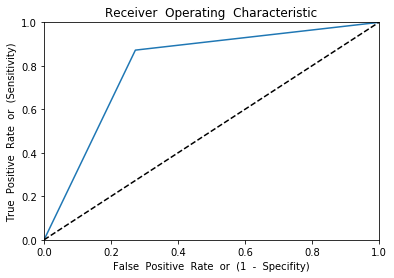

In [33]:
model.fit(X_train_norm, y_train) # Training the model

y_pred  =  model.predict(X_test_norm)  #  Predicting  labels  for  our  test  set  using trained
evaluate_on_training_set(y_test,  y_pred)  #evaluate  our  model  using  newly  defined  funct

Not a bad result! Gaussian models often perform well with smaller datasets as they fit the limited data to a distribution. 

### Model 5: SVM

Support Vector Machines offer a very powerful way to transform our data by implementing a 'kernel trick'. Hence, when we define our model, we need to specify our kernel. The results will be highly dependant on the kernel value and the regularisation parameter C. 

The kernel can be: ‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’. If none is given, ‘rbf’ will be used.

In [34]:
from  sklearn.svm  import  SVC
model  =  SVC(C=10,  gamma='auto',  kernel='rbf')
model.fit(X_train_norm, y_train)

SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

As usual, we use the exact same commands to train and evaluate the model: 

AUC  is:   0.7983558994197292
              precision    recall  f1-score   support

           0       0.88      0.68      0.77        44
           1       0.75      0.91      0.83        47

    accuracy                           0.80        91
   macro avg       0.82      0.80      0.80        91
weighted avg       0.82      0.80      0.80        91

Confusion Matrix: 
 [[30 14]
 [ 4 43]]


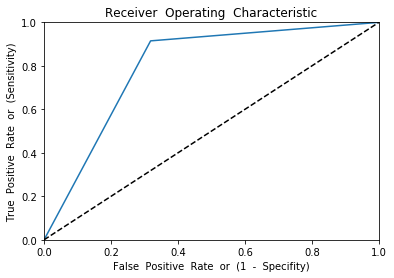

In [35]:
model.fit(X_train_norm, y_train) # Training SVM

y_pred  =  model.predict(X_test_norm)  #  Predicting  labels  for  our  test  set  using trained
evaluate_on_training_set(y_test,  y_pred)  


##### optimizing SVM using GridSearch 
Were you expecting better results from such a powerful model? Let's tweek the parameters to improve our accuracy...

We will be using Grid Search to tune parameters and try a range: 
- with kernel rbf, try varying gamma (which is a coefficient in the rbf kernel) to be 1e-3 or 1e-4; and vary C to be 1, 10, or 100.
- with linear kernel (there is no gamma here), try varying C to be 1, 10, and 100.

These values are stored as tuned_parameters. 

In [36]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

tuned_parameters  =  [{'kernel':  ['rbf'],
'gamma':  [1e-3,  1e-4],
'C':  [1,  10,  100]},
{'kernel':  ['linear'],
'C':  [1,  10,  100]}]

Using the above parameters, we can run a GridSearch algorithm to optimize the AUC score. The verbose output will output the process; n_jobs will parallize the computation over 4 processors; 2-fold CV is used during the search (cv = 2). 

In [37]:
clf  =  GridSearchCV(SVC(),  tuned_parameters,  cv=2,
scoring='roc_auc',  verbose=1,  n_jobs=4)

# train the model on the training set:
clf.fit(X_train_norm, y_train)

Fitting 2 folds for each of 9 candidates, totalling 18 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  18 out of  18 | elapsed:    2.0s finished


GridSearchCV(cv=2, error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='warn', n_jobs=4,
             param_grid=[{'C': [1, 10, 100], 'gamma': [0.001, 0.0001],
                          'kernel': ['rbf']},
                         {'C': [1, 10, 100], 'kernel': ['linear']}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='roc_auc', verbose=1)

Once this is trained we can again look at what the best parameters are and how well the model performs. 

Best parameter set found on development set:
{'C': 10, 'kernel': 'linear'} 

AUC  is:   0.8210831721470019
              precision    recall  f1-score   support

           0       0.89      0.73      0.80        44
           1       0.78      0.91      0.84        47

    accuracy                           0.82        91
   macro avg       0.84      0.82      0.82        91
weighted avg       0.83      0.82      0.82        91

Confusion Matrix: 
 [[32 12]
 [ 4 43]]


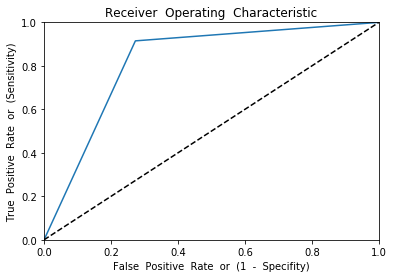

In [39]:
print("Best parameter set found on development set:")
print(clf.best_params_,  '\n')

y_pred = clf.predict(X_test_norm) #create predictions
evaluate_on_training_set(y_test, y_pred) # evaluate like we always do

### Model 5: AdaBoostClassifier (Ensemble method)

Ensemble models such as AdaBoost build multiple models and leverage the output to get a better result (most of the time). Sklearn tells us that: "AdaBoost is a meta-estimator that begins by fitting a classifier on the original dataset and then fits additional copies of the classifier on the same dataset but where the weights of incorrectly classified instances are adjusted such that subsequent classifiers focus more on difficult cases."

Let's define our model and set some parameters, learning rate can vary from 0 to 1; and n_estimators is the number of times a model is built. 

In [40]:
from  sklearn.ensemble  import  AdaBoostClassifier
model  =  AdaBoostClassifier(n_estimators=1000,  learning_rate=0.1)  #  Define  the  model  wi



How does it perform? 

AUC  is:   0.8239845261121856
              precision    recall  f1-score   support

           0       0.82      0.82      0.82        44
           1       0.83      0.83      0.83        47

    accuracy                           0.82        91
   macro avg       0.82      0.82      0.82        91
weighted avg       0.82      0.82      0.82        91

Confusion Matrix: 
 [[36  8]
 [ 8 39]]


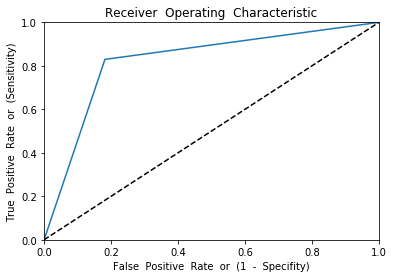

In [41]:
model.fit(X_train_norm, y_train) # Training the model

y_pred  =  model.predict(X_test_norm)  #  Predicting  labels  for  our  test  set  using trained
evaluate_on_training_set(y_test,  y_pred)  #evaluate  our  model  using  newly  defined  funct

### Model 6: RandomForestClassifier

Another ensemble classifier is Random Forest, which takes a bagging approach. We define the model: 

In [42]:
from  sklearn.ensemble  import  RandomForestClassifier
model  =  RandomForestClassifier(n_estimators  =  50)  #  Define  the  model

You can experiment with the parameters above (n_estimators is how many trees there are in the model), until you get good results. More parameters about the trees can be found [here](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html). 

AUC  is:   0.8104448742746615
              precision    recall  f1-score   support

           0       0.86      0.73      0.79        44
           1       0.78      0.89      0.83        47

    accuracy                           0.81        91
   macro avg       0.82      0.81      0.81        91
weighted avg       0.82      0.81      0.81        91

Confusion Matrix: 
 [[32 12]
 [ 5 42]]


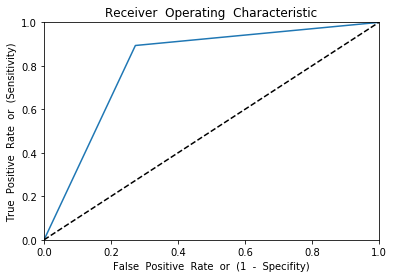

In [43]:
model.fit(X_train_norm, y_train) # Training the model

y_pred  =  model.predict(X_test_norm)  #  Predicting  labels  for  our  test  set  using trained
evaluate_on_training_set(y_test,  y_pred)  #evaluate  our  model  using  newly  defined  funct

This is an excellent model and trained quite fast. 

# Let's try on a new dataset...

Find the best performing model to predict student's academic performance and the following dataset: https://www.kaggle.com/aljarah/xAPI-Edu-Data. The goal is to estimate the grade level of the student: 

The students are grouped into three numerical intervals based on their total grade/mark:
* Low-Level: interval includes values from 0 to 69,
* Middle-Level: interval includes values from 70 to 89,
* High-Level: interval includes values from 90-100.

Some steps for you to follow: 

1. Load the csv file as dataframe directly from

 https://dorienherremans.com/drop/CDS/classification/xAPI-Edu-Data.csv
2. Check if columns are recognised as categorical, is not, change them to categorical with the command: 

for key in ['gender','NationalITy','PlaceofBirth','StageID','GradeID','SectionID','Topic','Semester',
'Relation',

'ParentAnsweringSurvey','ParentschoolSatisfaction',
'StudentAbsenceDays','Class']:

    data[key] = pd.Categorical(data[key])
    data[key] = data[key].cat.codes

3. Preprocess the data to create a normalized training set with 30% split.
4. Train and evaluate multiple models to find the best classifier. 

IMPORTANT: Evaluate **only** in terms of classification_report and confusion matrix. (No need for AUC and ROC here, as we are doing multiclass classification, the target label would need to be binarized first, which we are not doing.)

We are trying to reach the **best recall performance** for predicting high grade students (class 0), in other words: number of correctly predicted high grade students over the total number of high grade students. 

**Fill in your best performing recall score for class 0 in our high score list: 
https://forms.gle/wquRxxjVBfgnVtht8**


In [102]:
data = pd.read_csv('grade.csv')

In [103]:
data

,gender,NationalITy,PlaceofBirth,StageID,GradeID,SectionID,Topic,Semester,Relation,raisedhands,VisITedResources,AnnouncementsView,Discussion,ParentAnsweringSurvey,ParentschoolSatisfaction,StudentAbsenceDays,Class
0,M,KW,KuwaIT,lowerlevel,G-04,A,IT,F,Father,15,16,2,20,Yes,Good,Under-7,M
1,M,KW,KuwaIT,lowerlevel,G-04,A,IT,F,Father,20,20,3,25,Yes,Good,Under-7,M
2,M,KW,KuwaIT,lowerlevel,G-04,A,IT,F,Father,10,7,0,30,No,Bad,Above-7,L
3,M,KW,KuwaIT,lowerlevel,G-04,A,IT,F,Father,30,25,5,35,No,Bad,Above-7,L
4,M,KW,KuwaIT,lowerlevel,G-04,A,IT,F,Father,40,50,12,50,No,Bad,Above-7,M
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
475,F,Jordan,Jordan,MiddleSchool,G-08,A,Chemistry,S,Father,5,4,5,8,No,Bad,Above-7,L
476,F,Jordan,Jordan,MiddleSchool,G-08,A,Geology,F,Father,50,77,14,28,No,Bad,Under-7,M
477,F,Jordan,Jordan,MiddleSchool,G-08,A,Geology,S,Father,55,74,25,29,No,Bad,Under-7,M
478,F,Jordan,Jordan,MiddleSchool,G-08,A,History,F,Father,30,17,14,57,No,Bad,Above-7,L


Helpful code to categorise the attributes (and save you typing time): 

In [107]:
for key in ['gender','NationalITy','PlaceofBirth','StageID','GradeID','SectionID','Topic','Semester','Relation','ParentAnsweringSurvey','ParentschoolSatisfaction','StudentAbsenceDays','Class']:

    data[key] = pd.Categorical(data[key])
    data[key] = data[key].cat.codes

data.head()

,gender,NationalITy,PlaceofBirth,StageID,GradeID,SectionID,Topic,Semester,Relation,raisedhands,VisITedResources,AnnouncementsView,Discussion,ParentAnsweringSurvey,ParentschoolSatisfaction,StudentAbsenceDays,Class
0,1,4,4,2,1,0,7,0,0,15,16,2,20,1,1,1,2
1,1,4,4,2,1,0,7,0,0,20,20,3,25,1,1,1,2
2,1,4,4,2,1,0,7,0,0,10,7,0,30,0,0,0,1
3,1,4,4,2,1,0,7,0,0,30,25,5,35,0,0,0,1
4,1,4,4,2,1,0,7,0,0,40,50,12,50,0,0,0,2


In [72]:
x_train, x_test, y_train, y_test = train_test_split(data.drop('Class', axis=1), data.loc[:, 'Class'], test_size=0.3, random_state=0) 

In [124]:
from  sklearn.ensemble  import  RandomForestClassifier
model  =  RandomForestClassifier(n_estimators  =  200)  #  Define  the  model
model.fit(x_train, y_train) # Training the model
y_pred  =  model.predict(x_test)  #  Predicting  labels  for  our  test  set  using trained
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.77      0.69      0.73        39
           1       0.80      0.94      0.86        34
           2       0.80      0.77      0.79        71

    accuracy                           0.79       144
   macro avg       0.79      0.80      0.79       144
weighted avg       0.79      0.79      0.79       144



In [129]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

tuned_parameters  =  [{'max_features':  ['sqrt', 'log2', 0.5, 0.7], 'max_leaf_nodes': [None,3,5,7,9,25]},]



clf  =  GridSearchCV(model,  tuned_parameters,  cv=5, scoring='recall_micro',  verbose=1,  n_jobs=4)

# train the model on the training set:
clf.fit(x_train, y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.0s
[Parallel(n_jobs=4)]: Done 120 out of 120 | elapsed:   10.0s finished
/Users/pengfei/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=200, n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                                              warm_start=False),
             iid='w

In [130]:
y_pred  =  model.predict(x_test)  #  Predicting  labels  for  our  test  set  using trained
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.77      0.69      0.73        39
           1       0.80      0.94      0.86        34
           2       0.80      0.77      0.79        71

    accuracy                           0.79       144
   macro avg       0.79      0.80      0.79       144
weighted avg       0.79      0.79      0.79       144



In [128]:
print(classification_report(y_test, np.zeros(len(y_test))))

              precision    recall  f1-score   support

           0       0.27      1.00      0.43        39
           1       0.00      0.00      0.00        34
           2       0.00      0.00      0.00        71

    accuracy                           0.27       144
   macro avg       0.09      0.33      0.14       144
weighted avg       0.07      0.27      0.12       144



In [125]:
import xgboost as xgb

In [126]:
xgmat = xgb.DMatrix(x_train, label=y_train)

/Users/pengfei/miniconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


In [134]:
# param = {}
# # use logistic regression loss, use raw prediction before logistic transformation
# # since we only need the rank
# param['objective'] = 'binary:logitraw'
# # scale weight of positive examples
# param['scale_pos_weight'] = sum_wneg/sum_wpos
# param['eta'] = 0.1
# param['max_depth'] = 6
# param['eval_metric'] = 'auc'
# param['silent'] = 1
# param['nthread'] = 16

clf = xgb.train({}, xgmat)

In [138]:
y_pred = clf.predict(xgb.DMatrix(x_test))

In [142]:
print(classification_report(np.round(y_pred), y_test))

              precision    recall  f1-score   support

         0.0       0.36      0.88      0.51        16
         1.0       0.85      0.36      0.50        81
         2.0       0.51      0.77      0.61        47

    accuracy                           0.55       144
   macro avg       0.57      0.67      0.54       144
weighted avg       0.69      0.55      0.54       144

